In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import mpld3
import pandas as pd
import imp
import numpy as np
import os
from sqlalchemy import create_engine
sn.set_context('notebook')

# RID loads estimation

The [exploratory notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/rid_data_exploration.ipynb) documented initial code for estimating loads and also demonstrated that the results are comparable to those reported previously. This notebook develops the code further and applies it more generally to produce standard plots for the report.

In [2]:
# Connect to db
resa2_basic_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template'
                    r'\useful_resa2_code.py')
resa2_basic = imp.load_source('useful_resa2_code', resa2_basic_path)
engine, conn = resa2_basic.connect_to_resa2()

# Import custom RID functions
rid_func_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
                 r'\Python\rid\notebooks\useful_rid_code.py')
rid = imp.load_source('useful_rid_code', rid_func_path)

In [3]:
# Read site data
in_xlsx = r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Data\RID_Sites_List.xlsx'

rid_11_df = pd.read_excel(in_xlsx, sheetname='RID_11')
rid_36_df = pd.read_excel(in_xlsx, sheetname='RID_36')
rid_108_df = pd.read_excel(in_xlsx, sheetname='RID_108')

# Drop the 37th site (with no NVE code) from RID_36
rid_36_df.dropna(how='any', inplace=True)

## 1. Load estimation workflow

The basic approach to estimating loads is documented in the [exploratory notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/rid_data_exploration.ipynb). However, a number of further modifications are required to make the workflow here compatible with what has been done previously. 

My initial code focused on estimating loads where observations are available, and the output compares favourably to the values presented on pages 117 to 142 of the 2015 report. However, there are some important differences - most notably, some of the published plots include "*extra or interpolated*" loads. In most cases, we do not have data in RESA2 for these years, so they have clearly been estimated using an alternative method. Strangely, though, in some cases, we **do** have data for these years, but these data have not been used in the loads calculations (see e.g. Hg from 1999 to 2003 at site 29615). **Need to check why estimated rather than measured values have been used here**. 

Looking at RESA2, it seems as though most of Tore's code for interpolation and patching is located in the procedures `CALCULATE_RID_STATISTICS`, `FIXNON109` and `FIX_NEGATIVE_VALUES`. As far as I can tell, when there are no water chemistry observations for a particular parameter in the specified year, values are inferred using the following workflow:

 1. Data for all years between 1990 and the present day are extracted for the parameter of interest and the **average concentration in each year** is calculated. <br><br>
 
 2. The **Theil-Sen estimator** is used to fit a simple linear regression line to the observed annual averages. <br><br>
 
 3. Values are inferred in two ways:
    
    i. For **interpolation** of missing data (i.e. the missing years have measured data *both before and after*), the fitted regression line is used to estimate the annual concentration in the year of interest. 
    
    ii. For **extrapolation** of missing data (i.e. estimating values *before the start or after the end* of the observed series), the fitted regression line is used to estimate the concentration for the first or last year in the observed series, and this value is assumed to remain constant for all previous or later years, respectively. Note that this approach is especially relevant for the RID_108 rivers, where fluxes post-2003 have been estimated by using a regression line to calculate 2003 concentrations, and then forward-filling.
    
    In all cases, inferred concentrations are assigned to June 30th (i.e. the middle of the year), and loads are then estimated using the standard OSPAR methodology. 
    
This approach seems over-complicated given the errors involved, and I'm not sure it is really justified. Either a dataset exhibits a linear trend, in which case regression can be used for both interpolation and extrapolation, or it does not, in which case linear regression is inappropriate. Using regression to estimate concentrations for e.g. 2003 and then forward-filling seems unnecessary, because we already have measured data for these sites from 2003. A simpler and more defensible approach in my opinion would be to forward-fill from either the median of the whole series or the last measured value (similarly, we could backward-fill from either median or the first measured value). Regardless, I'm not sure it's meaningful to report e.g. 2016 loads when the last measured chemistry values are from 2003.

Nevertheless, in order to maintain compatibility with previous analyses, I have added a function to my loads estimation code that implements more-or-less this workflow. The `estimate_loads` function can now be called using the option `infer_missing=True`, in which case loads are inferred for years even when no observations are available. My approach broadly follows the steps outlined above, but note the following:

 * Sen's slope is only used if the number of years with data is greater than 2 (i.e the minimum possible). If two or fewer years of data are available, the median is used for both interpolation and extrapolation. <br><br>
 
 * The Sen's slope equation is only used if the estimated slope is significantly different from zero at p < 0.05. Otherwise, the median of the series is used instead. <br><br>

**Note 1:** When I first wrote my function for calculating loads, I had not anticipated this part of the workflow. My code is therefore inefficient for these calculations, because there's a substantial overhead in the repeated calls now being made to the database. Using `infer_missing=True` therefore causes a significant slow-down - **use with caution**. If this functionality is desirable, it would be straightforward to refactor the code to make it faster, but I have not looked at this yet.

**Note 2:** In Tore's RESA2 workflow, most of the relevant data, both observed and interpolated, is written to the tables `RESA2.RID_TIMESERIES` and `RIS_TIMESERIES_STATISTICS`. The `ESTIMATED` column in the former specifies whether the value is observed or estimated (by regression), whereas the `ESTIMATE_TYPE` column specifies how LOD values have been handled (0 = "lower estimate"; 1 = "upper estimate"; 2 = "OSPAR estimate").

## 2. Loads for current year for all rivers

Loads for the RID_11 and RID_36 rivers for 2015 were already calculated in the [first notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/rid_data_exploration.ipynb) using `infer_missing=False`. 

Pages 186 to 195 of the report tabulate 2015 load estimates for all 155 main rivers in the RID programme. These loads are estimated below using `infer_missing=True`.

In [4]:
# Sites of interest: combine RID_11 and RID_36
rid_all_df = pd.concat([rid_11_df, rid_36_df, rid_108_df], axis=0)

# Pars of interest
par_list = ['SPM', 'TOC', 'PO4-P', 'TOTP', 'NO3-N', 'NH4-N', 
            'TOTN', 'SiO2', 'Ag', 'As', 'Pb', 'Cd', 'Cu', 
            'Zn', 'Ni', 'Cr', 'Hg']

# Year of interest
year = 2015

# Container for results from each site
loads_list = []

# Loop over sites
for stn_id in rid_all_df['station_id'].values:
    # Estimate loads at this site
    loads_list.append(rid.estimate_loads(stn_id, par_list, 
                                         year, engine,
                                         infer_missing=True))

# Concatenate to new df
lds_all = pd.concat(loads_list, axis=0)

# Save output
out_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Results\Loads_CSVs\loads_all_sites_%s.csv' % year)
lds_all.to_csv(out_csv)

lds_all.head()

    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated value

,Ag_Est,Ag_tonnes,As_Est,As_tonnes,Cd_Est,Cd_tonnes,Cr_Est,Cr_tonnes,Cu_Est,Cu_tonnes,...,SiO2_Est,SiO2_tonnes,TOC_Est,TOC_tonnes,TOTN_Est,TOTN_tonnes,TOTP_Est,TOTP_tonnes,Zn_Est,Zn_tonnes
29615,0.0,0.026935,0,0.857642,0,0.061187,0,0.748727,0,3.345883,...,0,15193.268316,0,19867.864209,0,1810.534032,0,53.897994,0,14.065115
29821,0.0,0.002379,0,0.305334,0,0.023144,0,0.217992,0,1.302675,...,0,3851.033678,0,4137.734303,0,733.010498,0,13.685448,0,4.635285
29783,0.0,0.000325,0,0.053566,0,0.002794,0,0.037010,0,0.404016,...,0,366.082323,0,1114.443010,0,349.411826,0,12.165597,0,0.832640
29613,0.0,0.004527,0,1.221973,0,0.097865,0,0.850659,0,4.698857,...,0,24107.532086,0,32394.229840,0,2916.501627,0,37.401742,0,32.971022
29614,0.0,0.016655,0,0.700739,0,0.096378,0,0.505428,0,2.750329,...,0,9341.694816,0,17665.700424,0,1330.250807,0,16.437358,0,17.993453


## 3. Loads for RID_11 rivers through time

Pages 117 to 142 of the 2015 report show bar charts of loads through time for 10 of the RID_11 rivers. The code below estimates loads for these sites from 1990 to 2015 (also using `infer_missing=True`).

In [5]:
# Period of interest
st_yr, end_yr = 1990, 2015

# Container for results 
loads_list = []

# Loop over sites
for stn_id in rid_11_df['station_id'].values:
    # Loop over years
    for year in range(st_yr, end_yr+1):
        print 'Processing Station ID %s for %s' % (stn_id, year)
        
        # Get loads
        l_df = rid.estimate_loads(stn_id, par_list, 
                                  year, engine,
                                  infer_missing=True)
        
        if l_df is not None:
            # Name and reset index
            l_df.index.name = 'station_id'
            l_df.reset_index(inplace=True)

            # Add year
            l_df['year'] = year

            # Add to outout
            loads_list.append(l_df)

# Concatenate to new df
lds_ts = pd.concat(loads_list, axis=0)

# Build multi-index
lds_ts.set_index(['station_id', 'year'], inplace=True)

# Save output
out_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Results\Loads_CSVs\loads_ts_11-36_%s-%s.csv' % (st_yr, end_yr))
lds_ts.to_csv(out_csv)

Processing Station ID 29615 for 1990
    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

Processing Station ID 29615 for 1991
    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

Processing Station ID 29615 for 1992
    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

Processing Station ID 29615 for 1993
Processing Station ID 29615 for 1994
  

In [6]:
lds_ts.head(10)

Ag_Est  Ag_tonnes  As_Est  As_tonnes  Cd_Est  Cd_tonnes  \
station_id year                                                            
29615      1990       1   0.085938       1   0.683296       0   0.222929   
           1991       1   0.066964       1   0.532427       0   0.103327   
           1992       1   0.066751       1   0.530737       0   0.648627   
           1993       1   0.083801       0   0.722654       0   0.246591   
           1994       1   0.091918       1   0.730843       0   0.173729   
           1995       1   0.091895       0   1.184851       0   0.437357   
           1996       1   0.060598       0   0.000000       0   0.060975   
           1997       1   0.065014       0   0.330754       0   0.047388   
           1998       1   0.088375       0   0.531750       0   0.149452   
           1999       1   0.090974       0   0.821567       0   0.072666   

                 Cr_Est  Cr_tonnes  Cu_Est  Cu_tonnes     ...      SiO2_Est  \
station_id year                                           ...                 
29615      1990       1   1.361754       0   6.141421     ...             1   
           1991       1   1.061085       0   5.229627     ...             1   
           1992       0   2.714801       0   8.516817     ...             1   
           1993       0   2.158424       0  41.218089     ...             1   
           1994       1   1.375308       0   4.100236     ...             1   
           1995       0   0.000000       0   5.340730     ...             0   
           1996       0   0.000000       0   2.989012     ...             0   
           1997       0   0.753393       0   5.168681     ...             0   
           1998       0   0.000000       0   6.861382     ...             0   
           1999       0   1.094929       0   4.356622     ...             0   

                  SiO2_tonnes  TOC_Est    TOC_tonnes  TOTN_Est  TOTN_tonnes  \
station_id year                                                               
29615      1990  10787.870848        1  13994.152538         0  1232.892899   
           1991   8405.961819        0   8435.952595         0  1101.370789   
           1992   8379.277436        0  12336.054953         0  1317.074613   
           1993  10519.614504        0  15487.080312         0  1574.369044   
           1994  11538.539445        1  15228.781051         0  1727.713707   
           1995   9980.296594        0  13428.309998         0  1473.522451   
           1996   5871.825321        0   8855.011272         0  1143.282945   
           1997   8165.765267        0   9500.268474         0  1250.136261   
           1998  10867.065882        0  12913.920766         0  1608.345080   
           1999  12445.360361        0  17712.350174         0  1754.166686   

                 TOTP_Est  TOTP_tonnes  Zn_Est   Zn_tonnes  
station_id year                                             
29615      1990         0    38.797762       0   23.746553  
           1991         0    33.783983       0   28.917685  
           1992         0    24.100149       0   21.635558  
           1993         0    51.708226       0  155.889961  
           1994         0    33.734824       0   23.571308  
           1995         0    41.971192       0   23.934467  
           1996         0    28.970973       0   10.840110  
           1997         0    30.193807       0   14.835482  
           1998         0    43.020696       0   36.054357  
           1999         0    86.378963       0   21.687989  

[10 rows x 34 columns]

This dataframe can then be used to create point or bar plots, similar to those in the report. For now, my code produces one set of charts per site, rather than grouping by parameter as in the report, but this can easily be changed. As in the report, green bars represent estimates based on regression relationships, whereas blue bars are based directly on observational data.

In [8]:
%%capture
# This code cell produces lots of Deprecation Warnings from Seaborn/Pandas.
# %%capture suppresses all output from this cell to keep things tidy

# Output folder for plots
out_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\Results\TS_Plots')

# Loop over df
for stn_id in rid_11_df['station_id'].values:
    # Get data for this station
    df = lds_ts.ix[stn_id]
    
    # Separate est and val cols to two dfs
    cols = df.columns
    est_cols = [i for i in cols if i.split('_')[1]=='Est']
    val_cols = [i for i in cols if i.split('_')[1]!='Est']    
    val_df = df[val_cols]
    est_df = df[est_cols]
    
    # Convert to "long" format
    val_df.reset_index(inplace=True)
    val_df = pd.melt(val_df, id_vars='year', var_name='par_unit')    
    est_df.reset_index(inplace=True)
    est_df = pd.melt(est_df, id_vars='year', var_name='par_est', value_name='est')
    
    # Get just par for joining
    val_df['par'] = val_df['par_unit'].str.split('_', expand=True)[0]
    est_df['par'] = est_df['par_est'].str.split('_', expand=True)[0]
    
    # Join
    df = pd.merge(val_df, est_df, how='left',
                  on=['year', 'par'])
    
    # Extract cols of interest
    df = df[['year', 'par_unit', 'value', 'est']]

    # Plot
    g = sn.factorplot(x='year', y='value', hue='est',
                      col='par_unit', col_wrap=3,
                      data=df, 
                      kind='bar',
                      dodge=False,
                      sharex=False,
                      sharey=False,
                      alpha=0.5,
                      aspect=2,
                      legend=False)
    
    # Rotate tick labels and tidy
    for ax in g.axes.flatten(): 
        for tick in ax.get_xticklabels(): 
            tick.set(rotation=45)
    plt.tight_layout()
    
    # Save
    out_path = os.path.join(out_fold, '%s.png' % stn_id)
    plt.savefig(out_path, dpi=200)
    plt.close()      

An example of one of the plots is shown below.

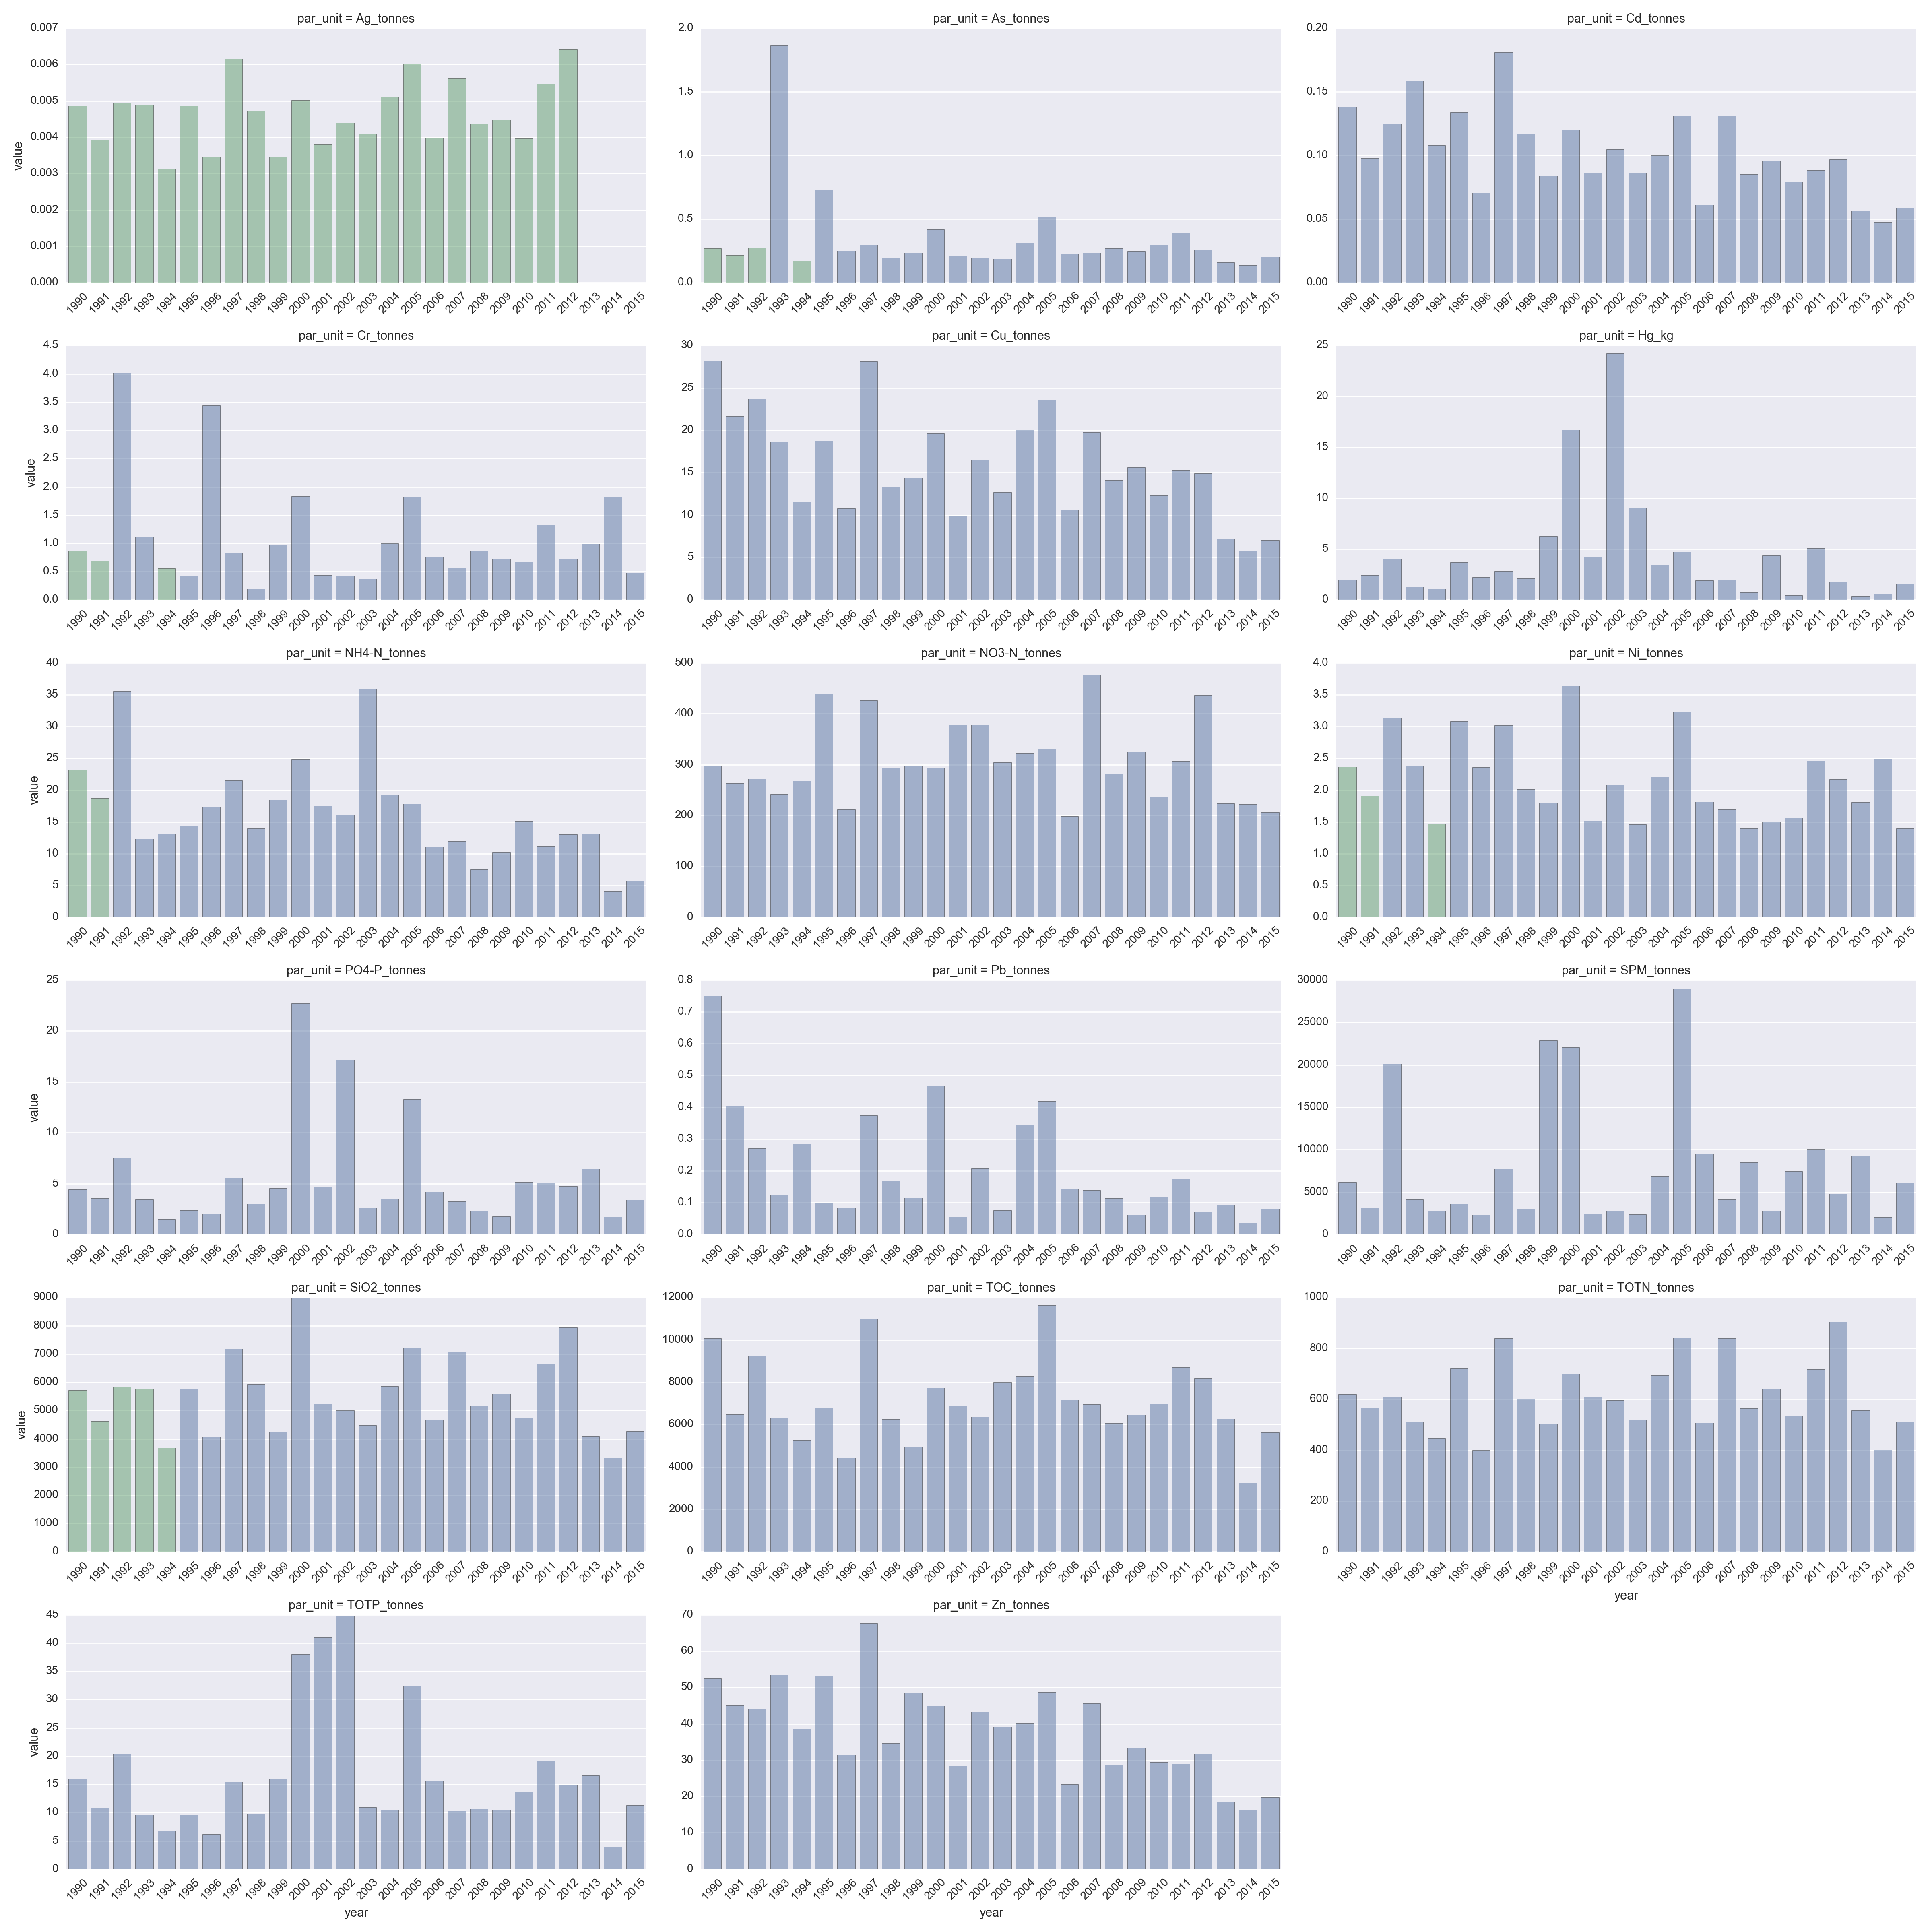

In [9]:
from IPython.display import Image
Image(out_path)